### This notebook will perform multiple linear regression on a set of climate variables from the CMIP6 archive. The dataset is monthly data in a historical climate simulation done with the CESM2 model. As will be seen below, there are many variables included in this dataset, and most of them will be loaded in to see if they can predict rainfall effectively. Each variable has an abbreviation used in the CMIP6 archive, and a list of those abbreviations can be found at [this link](https://pcmdi.llnl.gov/mips/cmip3/variableList.html). As will be seen below, the correlation coefficient is only roughly 0.1. Later in the notebook, a heat map is produced showing correlations between each variable that has been loaded in, and some interesting patterns there will be observed.

### The following two links are helpful sources:

http://www.arpnjournals.org/jeas/research_papers/rp_2017/jeas_0617_6115.pdf

https://github.com/patrol7171/Machine-Learning-and-Climate-Change#using-the-scikit-learn-linear-regression-module-to-predict-the-weather


In [34]:
## Importing some useful modules:

from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
# from nc_time_axis import NetCDFTimeConverter, CalendarDateTime
# import cftime
from scipy import stats
# from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import pca

import seaborn as sns

In [17]:
## Loading a CSV that can be queried for specific data
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv') 
df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ts,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
1,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,ua,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
2,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
3,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706
4,HighResMIP,CMCC,CMCC-CM2-HR4,highresSST-present,r1i1p1f1,Amon,tauu,gn,gs://cmip6/CMIP6/HighResMIP/CMCC/CMCC-CM2-HR4/...,NaN,20170706


### Below I list the variables for which there is monthly data in a historical simulation from CESM2:

In [18]:
all_vars = df.query("experiment_id == 'historical' & table_id == 'Amon' & source_id == 'CESM2'")
all_vars.head()
varlist = []
for i in all_vars['variable_id']:
    if i not in varlist:
        varlist.append(i)
print(varlist)

['o3', 'n2oglobal', 'psl', 'hurs', 'hus', 'huss', 'sfcWind', 'rtmt', 'rsutcs', 'rsut', 'rsdt', 'rsds', 'ta', 'rlutcs', 'rlus', 'rlds', 'ps', 'prw', 'rlut', 'tas', 'tauv', 'tauu', 'rsus', 'zg', 'wap', 'va', 'ua', 'ts', 'cfc11global', 'cfc12global', 'ch4global', 'cl', 'cli', 'clivi', 'clt', 'clw', 'evspsbl', 'hfls', 'hfss', 'hur', 'clwvi', 'sbl', 'rsuscs', 'rldscs', 'rsdscs', 'ci', 'pr', 'prc', 'co2mass', 'co2', 'prsn']


### Next I make a dictionary with query results for each variable:

In [19]:
vardict = {}
for variable in varlist:
    vardict[variable] = df.query("variable_id == '"+variable+"'& experiment_id == 'historical' & table_id == 'Amon' & source_id == 'CESM2'")


### Then I generate xarray datasets for each query result stored in vardict (excluding a few variables that were throwing errors due to formatting inconsistencies):

In [20]:
for variable in list(vardict.keys())[1:]: # Looping through each variable in vardict
    # The following two lines cause it to skip the variables 'cli', 'hur', 'hus', 'n2oglobal', and 'o3'
    if variable == 'cli' or variable == 'hur' or variable == 'hus' or variable == 'n2oglobal' or variable == 'o3':
        continue
    else: # The following lines generate xarray datasets:
        print(variable)
    #     print(0)
        zstore = vardict[variable].zstore.values[0] # the values[0] index just picks the first ensemble member (ensemble members are different runs of the model). Alternatively you could pick other ensemble members, or do this for each member, or average them.
    #     print(1)
        mapper = fsspec.get_mapper(zstore)
    #     print(2)
        ds = xr.open_zarr(mapper, consolidated=True, decode_times=True) # Opening the file using Xarray
        got_attribute = getattr(ds, variable) # ds is an Xarray Dataset, which includes multiple DataArrays (for example, ds.lat is a DataArray for latitude, and if there is a rainfall variable pr, ds.pr is a DataArray for rainfall). This line gets the DataArray representing the variable specified in the loop variable.
        print(got_attribute.shape) # Prints the shape of the selected DataArray

psl
(1980, 192, 288)
hurs
(1980, 192, 288)
huss
(1980, 192, 288)
sfcWind
(1980, 192, 288)
rtmt
(1980, 192, 288)
rsutcs
(1980, 192, 288)
rsut
(1980, 192, 288)
rsdt
(1980, 192, 288)
rsds
(1980, 192, 288)
ta
(1980, 19, 192, 288)
rlutcs
(1980, 192, 288)
rlus
(1980, 192, 288)
rlds
(1980, 192, 288)
ps
(1980, 192, 288)
prw
(1980, 192, 288)
rlut
(1980, 192, 288)
tas
(1980, 192, 288)
tauv
(1980, 192, 288)
tauu
(1980, 192, 288)
rsus
(1980, 192, 288)
zg
(1980, 19, 192, 288)
wap
(1980, 19, 192, 288)
va
(1980, 19, 192, 288)
ua
(1980, 19, 192, 288)
ts
(1980, 192, 288)
cfc11global
(1980,)
cfc12global
(1980,)
ch4global
(1980,)
cl
(1980, 32, 192, 288)
clivi
(1980, 192, 288)
clt
(1980, 192, 288)
clw
(1980, 32, 192, 288)
evspsbl
(1980, 192, 288)
hfls
(1980, 192, 288)
hfss
(1980, 192, 288)
clwvi
(1980, 192, 288)
sbl
(1980, 192, 288)
rsuscs
(1980, 192, 288)
rldscs
(1980, 192, 288)
rsdscs
(1980, 192, 288)
ci
(1980, 192, 288)
pr
(1980, 192, 288)
prc
(1980, 192, 288)
co2mass
(1980,)
co2
(1980, 19, 192, 288)
p

### Then I generate xarray datasets for each query result stored in vardict (excluding a few variables that were throwing errors due to formatting inconsistencies). I also restrict the data to only include one (latitude, longitude) point, which is roughly in the Northeast US. I also convert it to a numpy array and reshape the data so that it only includes the time dimension (after restricting the latitude and longitude, there are still 3 dimensions - but the spatial dimensions have size 1 so they can be eliminated). I also restrict it to the last 1200 time steps.

In [21]:
# The following is a list of some variables that will be ignored:
listNOT2dVars = ['ua', 'va', 'wap', 'zg', 'ta', 'clw', 'cfc11global', 'cfc12global', 'ch4global', 'cl', 'co2mass', 'co2']
formatted_Data = {} # Here I will store the data after reshaping it the way I want it
for variable in list(vardict.keys())[1:]:
    if variable == 'cli' or variable == 'hur' or variable == 'hus' or variable == 'n2oglobal' or variable == 'o3' or variable in listNOT2dVars: # I ignore all these variables for formatting/time reasons
        continue
    else:
        print(variable)
    #     print(0)
        zstore = vardict[variable].zstore.values[0] # the values[0] index just picks the first ensemble member (ensemble members are different runs of the model). Alternatively you could pick other ensemble members, or do this for each member, or average them.
    #     print(1)
        mapper = fsspec.get_mapper(zstore)
    #     print(2)
        ds = xr.open_zarr(mapper, consolidated=True, decode_times=True) # Opening the file using Xarray
    #     print(3)
        got_attribute = getattr(ds, variable) # ds is an Xarray Dataset, which includes multiple DataArrays (for example, ds.lat is a DataArray for latitude, and if there is a rainfall variable pr, ds.pr is a DataArray for rainfall). This line gets the DataArray representing the variable specified in the loop variable.
    #     print(4)
        dataNow = got_attribute.sel(lat=slice(41,42)) # Slicing latitude
    #     print(5)
        dataNow = dataNow.sel(lon=slice(289,290)) # Slicing longitude
    #     print(6)
        dataFinal = dataNow.values # Converting to a numpy array by using the .values attribute
    #     print(7)
        dataFinal = dataFinal.reshape((1980,)) # Reshaping to only include time (lat and lon have length 1 now so they can be eliminated)
    #     print(8)
        dataFinal = dataFinal[1200:] # Only looking at the last 1200 time steps
    #     print(9)
        formatted_Data[variable] = dataFinal # Adding the formatted data to the dictionary.

psl
hurs
huss
sfcWind
rtmt
rsutcs
rsut
rsdt
rsds
rlutcs
rlus
rlds
ps
prw
rlut
tas
tauv
tauu
rsus
ts
clivi
clt
evspsbl
hfls
hfss
clwvi
sbl
rsuscs
rldscs
rsdscs
ci
pr
prc
prsn


### Next I convert the data to a Pandas DataFrame and remove NaN entries:

In [22]:
allvars = pd.DataFrame(formatted_Data) # Converting the formatted_Data dictionary to a Pandas DataFrame
allvars = allvars.dropna(axis='columns', how ='all') # Some variables ended up having all NaN values. Not sure why this was. This line removes them
allvars

,psl,hurs,huss,sfcWind,rtmt,rsutcs,rsut,rsdt,rsds,rlutcs,...,evspsbl,hfls,hfss,clwvi,rsuscs,rldscs,rsdscs,ci,pr,prc
0,101417.328125,82.242279,0.003704,11.559198,-132.339783,28.534027,83.631165,163.305496,47.004738,247.634415,...,0.000073,183.406158,175.297836,0.116815,11.827110,234.735764,113.964188,0.005376,0.000095,6.087542e-07
1,101730.687500,79.499268,0.004264,11.618338,-83.873062,32.256042,95.219521,224.868530,87.983414,242.875839,...,0.000035,88.739784,66.292580,0.098157,13.048477,238.803757,161.600647,0.015625,0.000050,1.234739e-06
2,100919.867188,71.845741,0.003978,8.732610,1.920181,36.027252,79.414742,310.053619,181.747986,244.611389,...,0.000045,112.748268,79.420662,0.068126,13.827789,258.332306,225.707169,0.069892,0.000035,1.789454e-05
3,101303.039062,72.054878,0.005047,7.674854,60.961670,40.852386,105.902435,395.066132,218.115555,252.326202,...,0.000035,88.754509,30.409552,0.118675,15.082367,260.446533,299.414673,0.047222,0.000041,2.926323e-06
4,101849.062500,72.940384,0.007530,6.528949,108.084610,44.236542,116.386955,455.691864,253.518188,261.369568,...,0.000019,46.565311,-0.368612,0.054473,15.395538,293.835632,338.771179,0.042339,0.000054,3.674672e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,101793.242188,78.942154,0.015897,6.133240,88.050919,42.592499,81.276329,417.403687,248.839996,281.000244,...,0.000046,116.047409,10.590137,0.046731,14.020111,369.133911,296.522217,0.125672,0.000034,1.107464e-05
776,101958.585938,74.831245,0.012264,5.993644,0.197174,37.212402,95.098740,341.160217,175.844437,275.319244,...,0.000063,158.419632,26.495070,0.057014,13.207581,360.210754,239.150452,0.175694,0.000018,2.389647e-05
777,102071.976562,72.647491,0.008994,7.758755,-65.773834,33.543152,69.468773,254.335602,134.390442,272.249756,...,0.000081,202.259262,50.783081,0.081633,12.571640,339.579773,175.871475,0.151882,0.000054,1.827770e-05
778,101996.328125,71.863876,0.006924,9.050190,-114.743752,28.170380,68.662788,180.225830,77.163910,260.003693,...,0.000091,228.085464,84.861588,0.083428,11.593277,313.501495,122.097633,0.170139,0.000049,1.595682e-05


Here I generate a list of column names of the Pandas DataFrame which will be useful in a minute:

In [23]:
columnList = []
for col in allvars.columns:
    if col!='pr':
        columnList.append(col)
print(columnList)

['psl', 'hurs', 'huss', 'sfcWind', 'rtmt', 'rsutcs', 'rsut', 'rsdt', 'rsds', 'rlutcs', 'rlus', 'rlds', 'ps', 'prw', 'rlut', 'tas', 'tauv', 'tauu', 'rsus', 'ts', 'clivi', 'clt', 'evspsbl', 'hfls', 'hfss', 'clwvi', 'rsuscs', 'rldscs', 'rsdscs', 'ci', 'prc']


### Here I do simiple linear regression of the Pandas DataFrame.

In [24]:
regr = LinearRegression()
y=allvars['pr'] # I want to predict rainfall, which is represented by the 'pr' variable.
x=allvars[columnList] # I want to use all the other variables to predict rainfall.
model = regr.fit(x, y) # This generates the model
prediction = model.predict(x) # I'll graph the prediction later.

In [25]:
print('Correlation Coefficient:', regr.score(x, y)) # Prints the correlation coefficient of the model
print('Individual Coefficients:', regr.coef_) # Prints correlations between individual variables

Correlation Coefficient: 0.10920551132738021
Individual Coefficients: [ 3.2643315e-09 -5.3424156e-07  5.4593600e-04  3.8885705e-07
  1.7406999e-06  7.9316898e-08  1.4140693e-06 -1.8735288e-06
 -3.1097213e-07  2.2406414e-07  2.5853069e-07  2.9805850e-07
 -2.5701366e-10 -7.0024385e-07  1.6252027e-06  1.1127474e-06
 -4.1341867e-05  4.4141438e-05  2.5388777e-06 -3.6110098e-06
  1.0421931e-04 -5.9540753e-08 -1.0958110e-09 -1.7547777e-08
  3.6344876e-08 -2.6033162e-05 -2.4924816e-06 -9.5751503e-08
  4.3264060e-07  1.6698441e-05  3.2668293e-06]


### Plotting the prediction:

Text(0.5,0,'x')

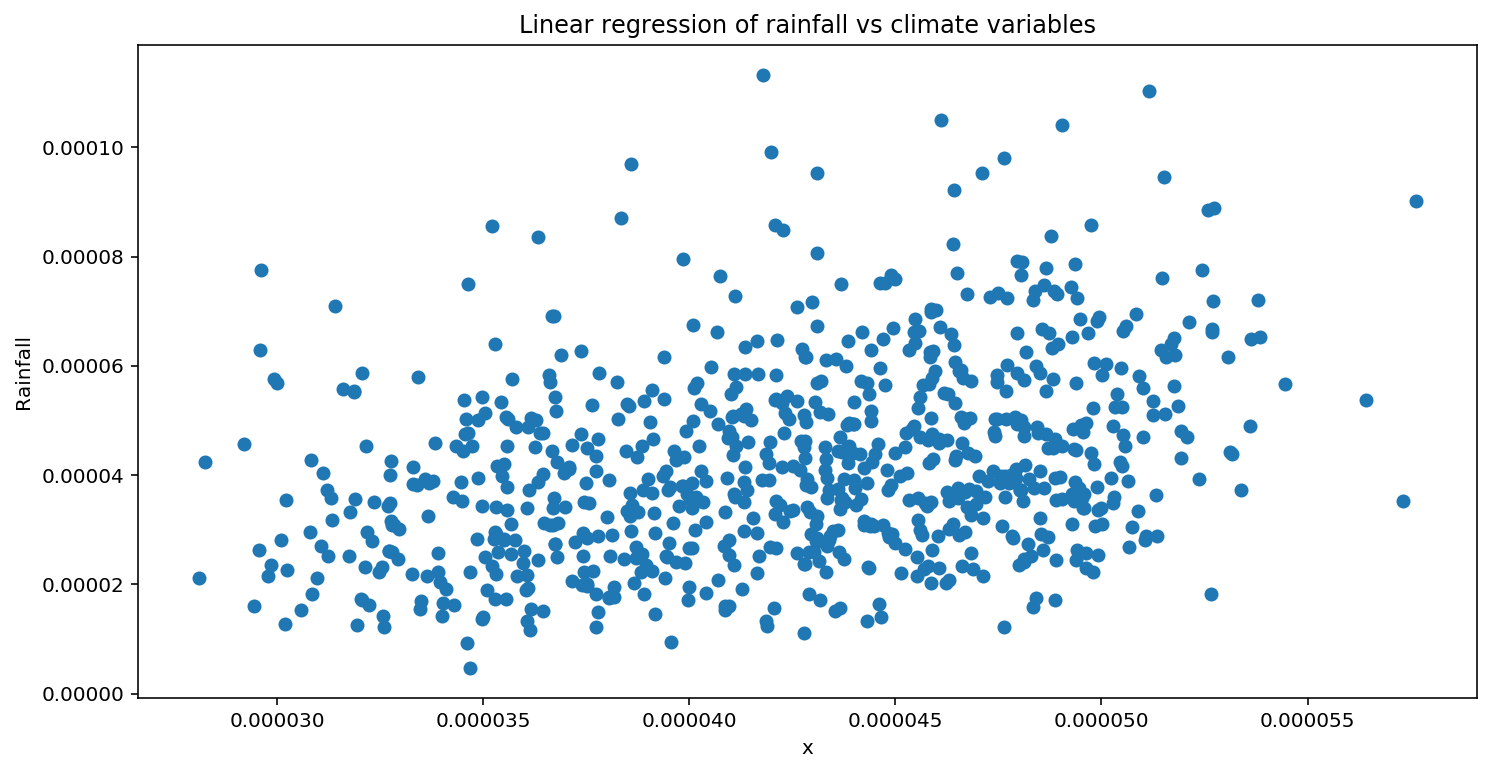

In [26]:
plt.figure(figsize=[12, 6])
plt.plot(prediction, allvars['pr'], 'o')
plt.title('Linear regression of rainfall vs climate variables')
plt.ylabel('Rainfall')
plt.xlabel('x')

### For the rest of this notebook I will work with normalized variables. In the following cell make a new DataFrame with normalized versions of each variable, where I normalize by subtracting the mean from each entry and dividing by the standard deviation.

In [27]:
NormalizedVars = allvars
for col in allvars.columns:
    NormalizedVars[col] = (NormalizedVars[col]-NormalizedVars[col].mean())/(NormalizedVars[col].std())
NormalizedVars

,psl,hurs,huss,sfcWind,rtmt,rsutcs,rsut,rsdt,rsds,rlutcs,...,evspsbl,hfls,hfss,clwvi,rsuscs,rldscs,rsdscs,ci,pr,prc
0,-0.741159,1.249103,-1.153212,2.064808,-1.351496,-1.264166,-0.330146,-1.314381,-1.498575,-1.152660,...,0.959134,0.959133,2.102506,1.055845,-1.035669,-1.366318,-1.291083,-1.286734,2.947223,-1.120786
1,0.185607,0.657023,-1.008533,2.097492,-0.851049,-0.757606,0.193127,-0.797569,-0.989853,-1.530971,...,-0.603706,-0.603707,0.181329,0.463952,-0.228101,-1.279170,-0.755357,-1.165604,0.395980,-1.050525
2,-2.212409,-0.994996,-1.082328,0.502651,0.034816,-0.244352,-0.520539,-0.082454,0.174170,-1.392993,...,-0.207352,-0.207353,0.412706,-0.488757,0.287180,-0.860812,-0.034408,-0.524207,-0.442737,0.819381
3,-1.079171,-0.949853,-0.805968,-0.081934,0.644453,0.412340,0.675515,0.631213,0.625648,-0.779660,...,-0.603463,-0.603464,-0.451096,1.114841,1.116707,-0.815519,0.794515,-0.792151,-0.082250,-0.860661
4,0.535704,-0.758716,-0.163658,-0.715235,1.131025,0.872917,1.148944,1.140156,1.065147,-0.060705,...,-1.299962,-1.299962,-0.993550,-0.921874,1.323776,-0.100226,1.237123,-0.849870,0.666758,-0.776666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
775,0.370614,0.536769,2.000156,-0.933930,0.924165,0.649166,-0.436479,0.818733,1.007070,1.499949,...,-0.152887,-0.152887,-0.800406,-1.167470,0.414344,1.512883,0.761986,0.135062,-0.444973,0.053912
776,0.859622,-0.350573,1.060651,-1.011079,0.017025,-0.083055,0.187673,0.178681,0.100881,1.048305,...,0.546633,0.546632,-0.520088,-0.841251,-0.122902,1.321723,0.116777,0.726285,-1.347492,1.493041
777,1.194977,-0.821937,0.214735,-0.035564,-0.664164,-0.582433,-0.969650,-0.550198,-0.413742,0.804278,...,1.270379,1.270377,-0.092021,-0.060262,-0.543386,0.879747,-0.594866,0.444839,0.620516,0.862387
778,0.971245,-0.991081,-0.320447,0.678167,-1.169807,-1.313657,-1.006044,-1.172338,-1.124169,-0.169293,...,1.696742,1.696740,0.508601,-0.003319,-1.190280,0.321074,-1.199613,0.660623,0.368075,0.601890


### Then I do linear regression with the normalized variables and make a plot, same as above. As can be seen, the plot has different values on the axes but is otherwise identical.

In [32]:
regr = LinearRegression()
Y=NormalizedVars['pr']
X=NormalizedVars[columnList]
model = regr.fit(X, Y)
prediction = model.predict(X)

Text(0.5,0,'x')

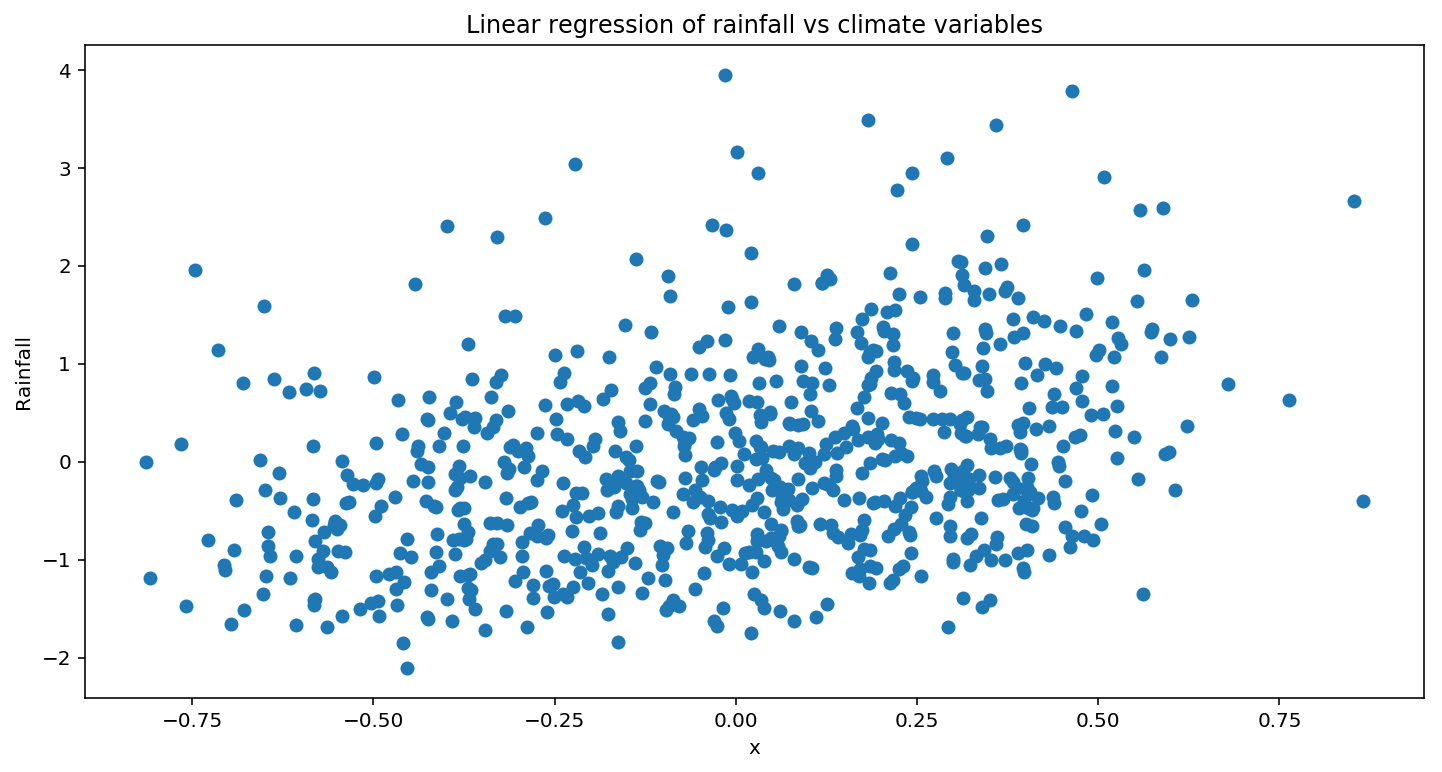

In [33]:
plt.figure(figsize=[12, 6])
plt.plot(prediction, allvars['pr'], 'o')
plt.title('Linear regression of rainfall vs climate variables')
plt.ylabel('Rainfall')
plt.xlabel('x')

### Printing out the coefficients again:

In [132]:
print('Correlation Coefficient:', regr.score(X, Y))
print('Individual Coefficients:', regr.coef_)
# print('Summary:', model.summary())

Correlation Coefficient: 0.0960459327544345
Individual Coefficients: [-4.71610464e-02  7.66831219e-01 -1.19231272e+01 -9.06719685e+00
  1.76165253e-01  3.11617017e+00  7.44910431e+01  6.03275597e-01
 -1.37445126e+01 -6.26526251e-02  2.05835205e+02 -2.06457031e+02
 -6.51397552e+01  3.15951228e-01  1.32900572e+00  2.60930568e-01
 -3.35925445e-02 -1.25005513e-01 -1.43367499e-01 -8.69956091e-02
 -3.42702150e-01 -1.04458645e-01  1.21908064e+01  1.25775859e-01
 -1.10594049e-01 -7.18285516e-02  3.80279981e-02 -5.90740561e-01
  1.50021052e+00 -1.23943232e-01 -1.02927916e-01]


### Below I print the individual coefficients again in a more convenient format. As can be seen, there are a few oddities. For example, the correlation of psl with pr is 205.8352 and the correlation of ps with pr is -206.45703. An explanation for this will be provided by the heat map in a moment.

In [137]:
# print(len(regr.coef_))
for i in range(len(columnList)):
    print(columnList[i], ':', regr.coef_[i])

clt : -0.047161046
rlds : 0.7668312
rlus : -11.923127
rlut : -9.067197
rlutcs : 0.17616525
rsds : 3.1161702
rsdt : 74.49104
rsus : 0.6032756
rsut : -13.744513
rsutcs : -0.062652625
psl : 205.8352
ps : -206.45703
rtmt : -65.139755
prw : 0.31595123
tas : 1.3290057
sfcWind : 0.26093057
clwvi : -0.033592544
evspsbl : -0.12500551
hfss : -0.1433675
hurs : -0.08699561
huss : -0.34270215
hfls : -0.104458645
ts : 12.190806
tauv : 0.12577586
tauu : -0.11059405
clivi : -0.07182855
ci : 0.038027998
rsuscs : -0.59074056
rsdscs : 1.5002105
rldscs : -0.12394323
prc : -0.102927916


### Below I show a heat map of the correlations between individual variables. There is a square of correlations of 1 for ps and psl, showing that these two variables are basically the same thing. Indeed, the [CMIP6 variables list](https://pcmdi.llnl.gov/mips/cmip3/variableList.html) confirms that they are the same: ps is "surface air pressure" and psl is "air pressure at sea level." I'm not sure why they are both part of the dataset, but their high correlation with each other most likely accounts for the weird correlations with rainfall.

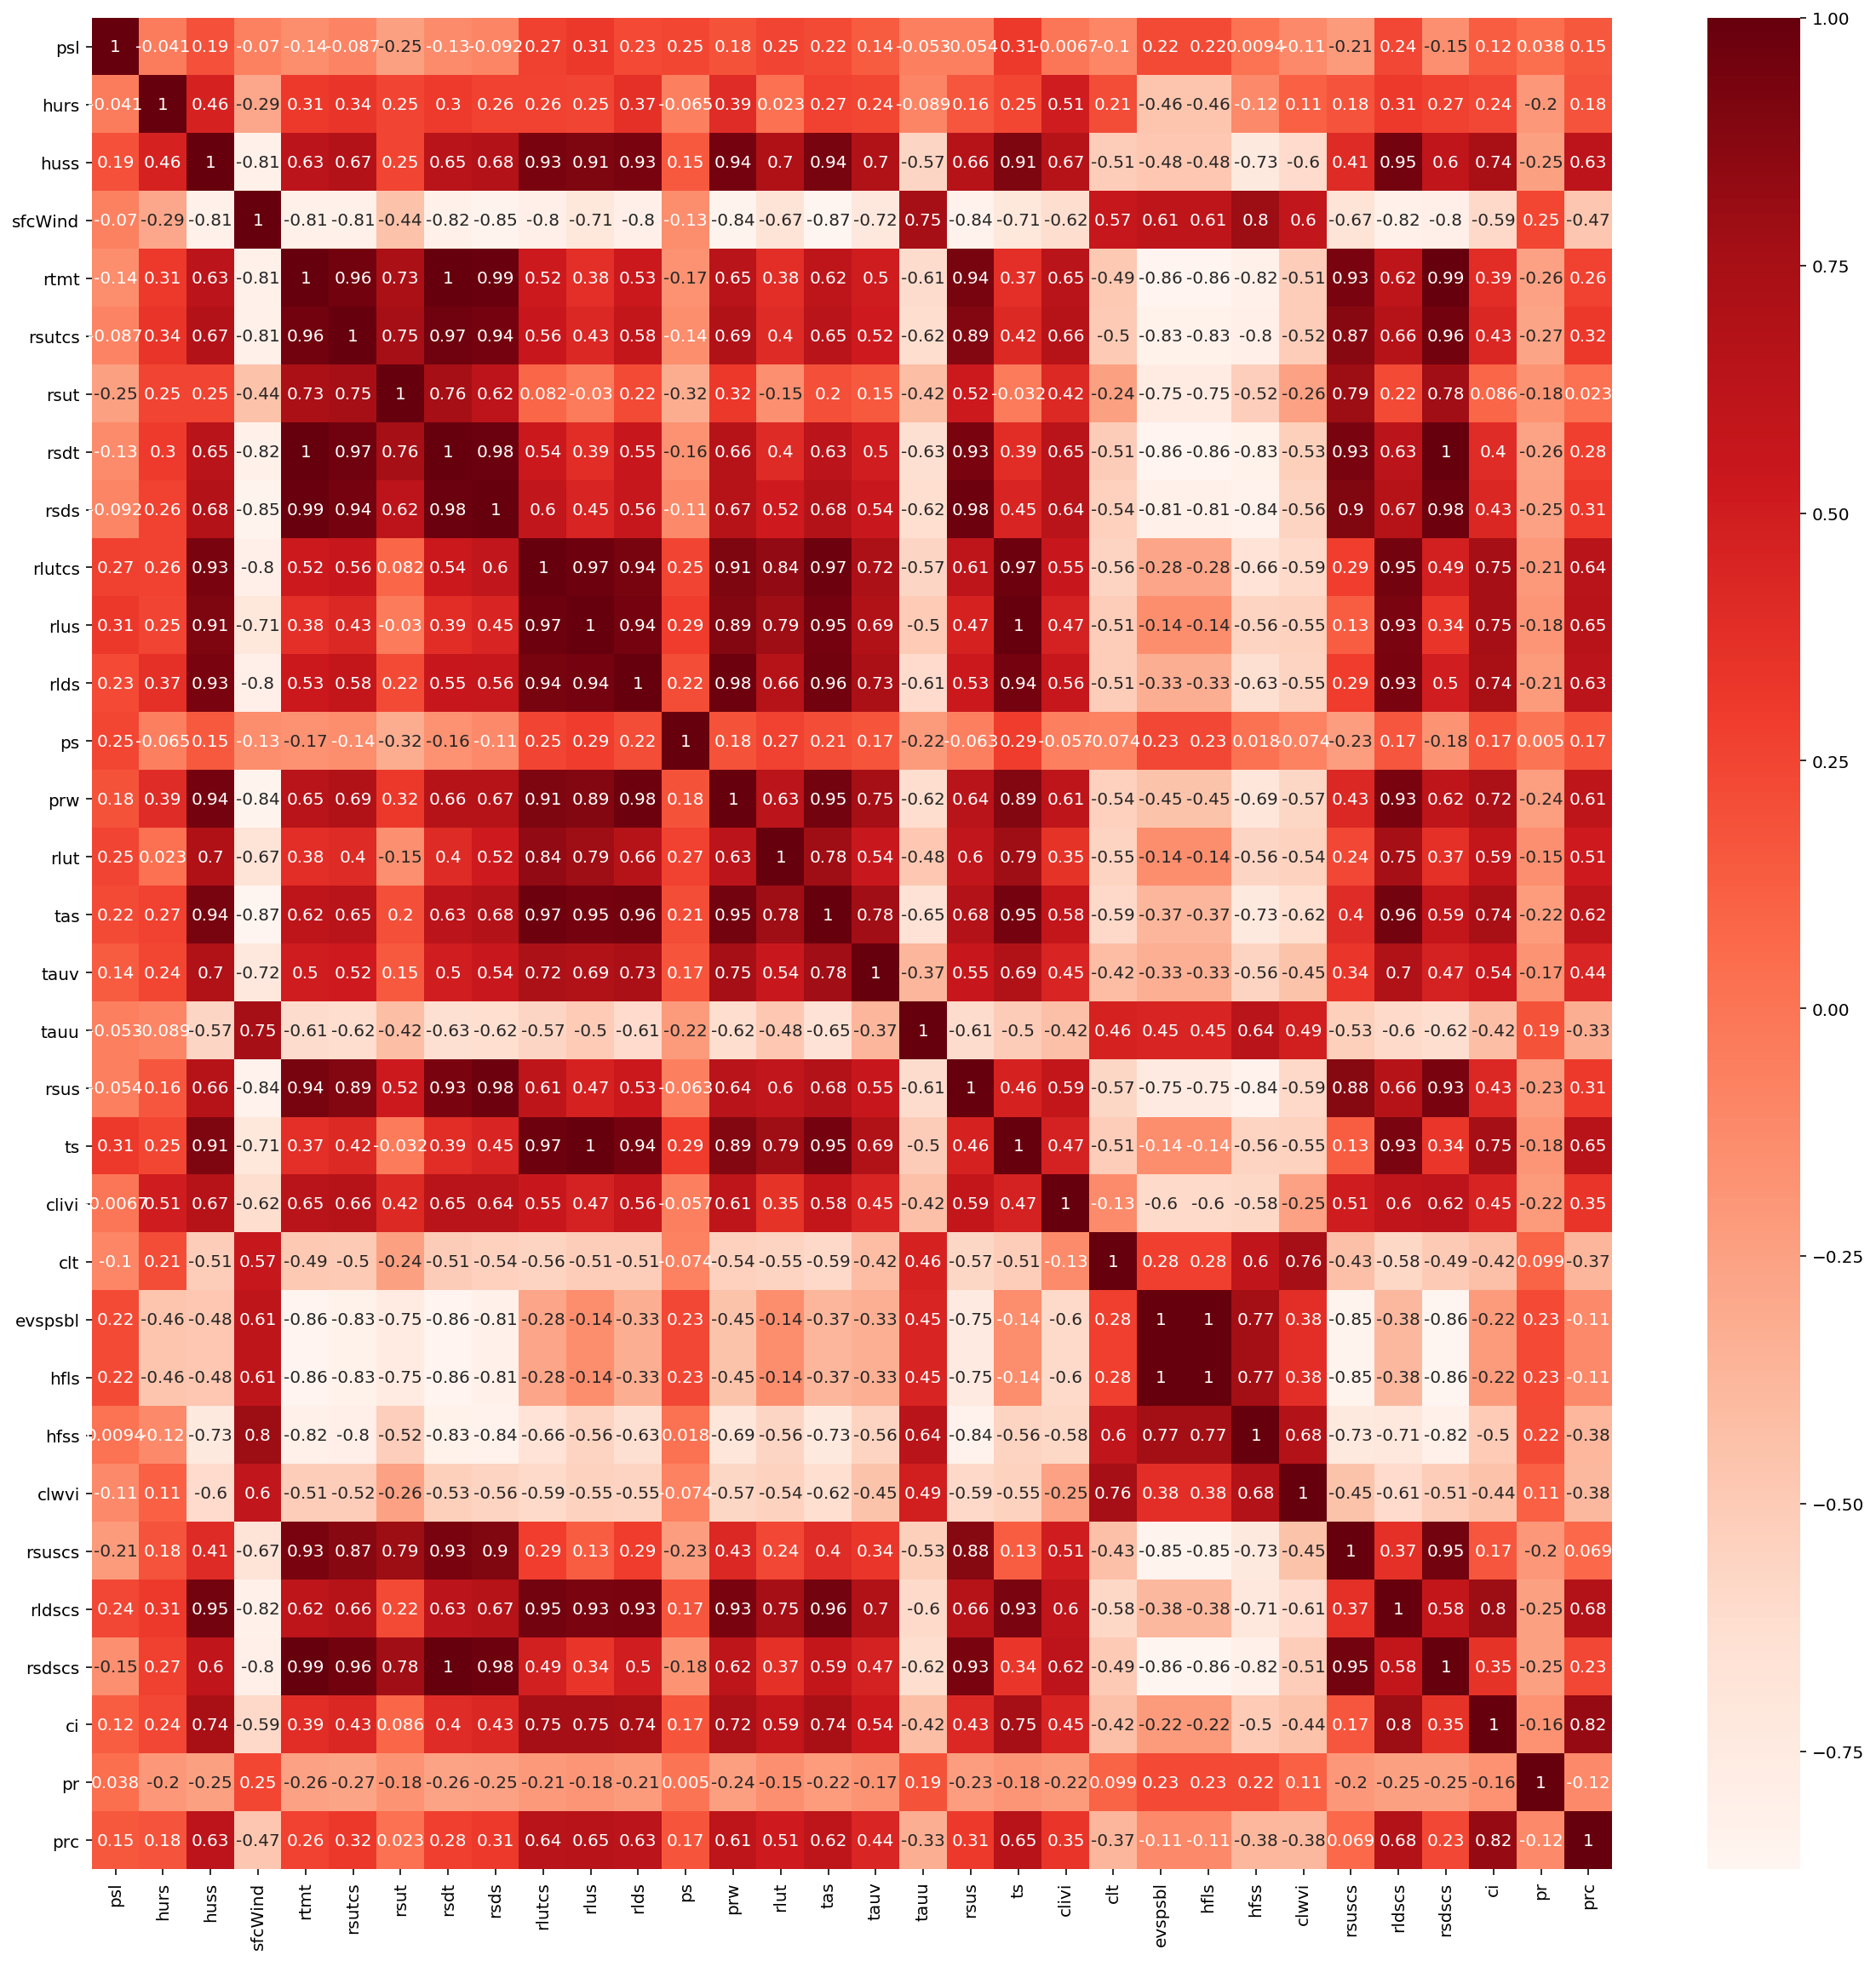

In [35]:
#Using Pearson Correlation
plt.figure(figsize=(20,20))
cor = NormalizedVars.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

### The following cells are less useful than everything above. They only use three variables from CMIP6 and as a result the fit is not as good. I start by loading in datasets for surface air temperature, sea level pressure, and rainfall separately:

In [36]:
tas_historical = df.query("variable_id == 'tas' & experiment_id == 'historical' & table_id == 'Amon' & source_id == 'CESM2'")
print(len(tas_historical))
psl_historical = df.query("variable_id == 'psl' & experiment_id == 'historical' & table_id == 'Amon' & source_id == 'CESM2'")
pr_historical = df.query("variable_id == 'pr' & experiment_id == 'historical' & table_id == 'Amon' & source_id == 'CESM2'")

11


### Putting the query results into a dictionary:

In [38]:
dataDict = {
    'tas': tas_historical,
    'psl': psl_historical,
    'pr': pr_historical
}

### The following cells do the same things for each of the three variables separately. Latitude and longitude are restricted in the same way as above, and the data is reshaped in the same way and has its time restricted to the last 1200 points.

In [39]:
# Accessing the file, getting it to just the lats and lons I want:
zstore = tas_historical.zstore.values[0] # By choosing index 0, I am looking at just the first of 11 available simulations meeting my specifications
mapper = fsspec.get_mapper(zstore)
ds = xr.open_zarr(mapper, consolidated=True, decode_times=True) # Opening the file using Xarray
ds.tas.lat
tas = ds.tas.sel(lat=slice(41,42))
tas = tas.sel(lon=slice(289,290))
tempdata = tas.values
tempdata = tempdata.reshape((1980,))
tempdata = tempdata[1200:]
tempdata.shape

(780,)

In [40]:
# Accessing the file, getting it to just the lats and lons I want:
zstore2 = psl_historical.zstore.values[0] # By choosing index 0, I am looking at just the first of 11 available simulations meeting my specifications
mapper2 = fsspec.get_mapper(zstore2)
ds2 = xr.open_zarr(mapper2, consolidated=True, decode_times=True) # Opening the file using Xarray
psl = ds2.psl.sel(lat=slice(41,42))
psl = psl.sel(lon=slice(289,290))
psldata = psl.values
psldata = psldata.reshape((1980,))
psldata = psldata[1200:]
psldata.shape

(780,)

In [41]:
# Accessing the file, getting it to just the lats and lons I want:
zstore3 = pr_historical.zstore.values[0] # By choosing index 0, I am looking at just the first of 11 available simulations meeting my specifications
mapper3 = fsspec.get_mapper(zstore3)
ds3 = xr.open_zarr(mapper3, consolidated=True, decode_times=True) # Opening the file using Xarray
pr = ds3.pr.sel(lat=slice(41,42))
pr = pr.sel(lon=slice(289,290))
prdata = pr.values
prdata = prdata.reshape((1980,))
prdata = prdata[1200:]
prdata.shape

(780,)

In [42]:
threeVars = pd.DataFrame({'tas': tempdata, 'psl': psldata, 'pr': prdata})
threeVars

,tas,psl,pr
0,273.004761,101417.328125,0.000095
1,271.679871,101730.687500,0.000050
2,275.457184,100919.867188,0.000035
3,282.004730,101303.039062,0.000041
4,286.751068,101849.062500,0.000054
...,...,...,...
775,299.060669,101793.242188,0.000034
776,295.535370,101958.585938,0.000018
777,292.085571,102071.976562,0.000054
778,283.429626,101996.328125,0.000049
